# Plot of Sagnac Drift of Rings

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory


In [2]:
from functions.load_sagnac_beat_data import __load_sagnac_beat_data
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.load_mlti import __load_mlti
from functions.smoothing import __smooth
from functions.interpolate_nan import __interpolate_nan
from functions.get_mlti_statistics import __get_mlti_statistics
from functions.get_lxx_intervals import __get_lxx_intervals
from functions.load_lxx import __load_lxx
from functions.find_max_min import __find_max_min
from functions.find_labels import __find_lables

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [4]:
config = {}

# specify length of time interval to show
config['time_interval'] = 21 # days

# define time interval
config['tend'] = UTCDateTime().now()
config['tbeg'] = config['tend'] - config['time_interval'] * 86400

Zlower, Zupper = 553.20, 553.55
Ulower, Uupper = 302.30, 302.60
Vlower, Vupper = 447.60, 447.80

# specify path to data
config['path_to_sds'] = archive_path+"romy_archive/"

# path to Sagnac beat data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

# path to figure output
config['path_to_figs'] = data_path+f"HTML_Monitor/figures/"


### Load beat data

In [5]:
try:
    beatU = __load_sagnac_beat_data(config['tbeg'], config['tend'], "U", config['path_to_autodata'])
except:
    beatU = DataFrame()
try:
    beatZ = __load_sagnac_beat_data(config['tbeg'], config['tend'], "Z", config['path_to_autodata'])
except:
    beatZ = DataFrame()
try:
    beatV = __load_sagnac_beat_data(config['tbeg'], config['tend'], "V", config['path_to_autodata'])
except:
    beatV = DataFrame()

error for 2024/RU/FJU_20241021.pkl
error for 2024/RZ/FJZ_20241021.pkl
error for 2024/RV/FJV_20241009.pkl
error for 2024/RV/FJV_20241021.pkl


In [6]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    time_scaling = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    try:
        ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj)
        ax[0].set_ylim(Zlower, Zupper)
        ax[0].ticklabel_format(useOffset=False)
    except:
        pass
    try:
        ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj)
        ax[1].set_ylim(Ulower, Uupper)
        ax[1].ticklabel_format(useOffset=False)
    except:
        pass
    try:
        ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj)
        ax[2].set_ylim(Vlower, Vupper)
        ax[2].ticklabel_format(useOffset=False)
    except:
        pass

    # ax[2].axhline(np.nanpercentile(beatV.fj, 99))
    # ax[2].axhline(np.nanpercentile(beatV.fj, 1))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)


    # ax[0].set_ylim(Zlower, Zupper)
    # ax[1].set_ylim(Ulower, Uupper)
    # ax[2].set_ylim(Vlower, Vupper)

    plt.show();
    return fig

In [7]:
# fig = __makeplot();

### Exclude Outliers

In [8]:
try:
    beatZ['fj'] = np.where((beatZ.fj > Zupper), np.nan, beatZ.fj)
    beatZ['fj'] = np.where((beatZ.fj < Zlower), np.nan, beatZ.fj)
except:
    pass
try:
    beatU['fj'] = np.where((beatU.fj > Uupper), np.nan, beatU.fj)
    beatU['fj'] = np.where((beatU.fj < Ulower), np.nan, beatU.fj)
except:
    pass
try:
    beatV['fj'] = np.where((beatV.fj > Vupper), np.nan, beatV.fj)
    beatV['fj'] = np.where((beatV.fj < Vlower), np.nan, beatV.fj)
except:
    pass

### Load Maintenance LXX log

In [9]:
try:
    # load log file
    lxx = __load_lxx(config['tbeg'], config['tend'], archive_path)

    # get intervals of maintenance work as utc times
    lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

except Exception as e:
    print(e)
    print(f" -> failed to load maintenance log")


### Remove MLTI times

In [10]:
try:
    # load mlti log
    mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

    # extract time intervals
    mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

    # set MLTI intervals to NaN
    beatU = __mlti_intervals_to_NaN(beatU, "fj", "times_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)

    # interpolate NaN values
    beatU['fj_inter'] = __interpolate_nan(np.array(beatU.fj_nan))

except:
    print(f" -> failed to load mlti log for RU")

In [11]:
try:
    # load mlti log
    mltiZ = __load_mlti(config['tbeg'], config['tend'], "Z", archive_path)

    # extract time intervals
    mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

    # set MLTI intervals to NaN
    beatZ = __mlti_intervals_to_NaN(beatZ, "fj", "times_utc", mltiZ_t1, mltiZ_t2, t_offset_sec=180)

    # interpolate NaN values
    beatZ['fj_inter'] = __interpolate_nan(np.array(beatZ.fj_nan))

except:
    print(f" -> failed to load mlti log for RZ")

In [12]:
try:
    # load mlti log
    mltiV = __load_mlti(config['tbeg'], config['tend'], "V", archive_path)

    # extract time intervals
    mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)

    # set MLTI intervals to NaN
    beatV = __mlti_intervals_to_NaN(beatV, "fj", "times_utc", mltiV_t1, mltiV_t2, t_offset_sec=180)

    # interpolate NaN values
    beatV['fj_inter'] = __interpolate_nan(np.array(beatV.fj_nan))

except Exception as e:
    print(f" -> failed to load mlti log for RV")
    print(e)

### Get MLTI statistics

In [13]:
try:
    mlti_statsU = __get_mlti_statistics(mltiU, config['tbeg'], config['tend'],
                                        intervals=True, plot=False, ylog=False
                                       )

    mlti_statsU["mlti_series_avg"] = __smooth(mlti_statsU["mlti_series"], 86400)

except Exception as e:
    print(e)
    print(f" -> failed to get MLTI statistics for RU")

try:
    mlti_statsV = __get_mlti_statistics(mltiV, config['tbeg'], config['tend'],
                                        intervals=True, plot=False, ylog=False
                                       )

    mlti_statsV["mlti_series_avg"] = __smooth(mlti_statsV["mlti_series"], 86400)

except Exception as e:
    print(e)
    print(f" -> failed to get MLTI statistics for RV")

try:
    mlti_statsZ = __get_mlti_statistics(mltiZ, config['tbeg'], config['tend'],
                                        intervals=True, plot=False, ylog=False
                                       )

    mlti_statsZ["mlti_series_avg"] = __smooth(mlti_statsZ["mlti_series"], 86400)

except Exception as e:
    print(e)
    print(f" -> failed to get MLTI statistics for RZ")



## Smoothing

In [14]:
n_minutes = 24*60

try:
    beatU['fj_smooth'] = __smooth(beatU.fj_inter, n_minutes)

    maskU = np.where(np.isnan(beatU.fj_nan), np.nan, 1)

    beatU['fj_smooth_masked'] = beatU['fj_smooth'] * maskU

except:
    pass

try:
    beatV['fj_smooth'] = __smooth(beatV.fj_inter, n_minutes)

    maskV = np.where(np.isnan(beatV.fj_nan), np.nan, 1)

    beatV['fj_smooth_masked'] = beatV['fj_smooth'] * maskV

except:
    pass

try:
    beatZ['fj_smooth'] = __smooth(beatZ.fj_inter, n_minutes)

    maskZ = np.where(np.isnan(beatZ.fj_nan), np.nan, 1)

    beatZ['fj_smooth_masked'] = beatZ['fj_smooth'] * maskZ

except:
    pass


## Plotting

In [15]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    # ref_date = UTCDateTime(str(beatV.times_utc.iloc[0])[:10])
    ref_date = config['tbeg']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(10, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    try:
        ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj, color="tab:grey", alpha=0.3, label="RZ (raw)")
        ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_nan, color="tab:blue", label="RZ (cleaned)")
        # ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_smooth_masked, color="k", label=f"mov. avg. ({n_minutes} min)")
    except:
        pass

    try:
        Z_min, Z_max = __find_max_min([beatZ.fj_nan], 99.9)
        ax[0].set_ylim(Z_min, Z_max)
    except:
        pass

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("Horizontal\nring (Hz)", fontsize=font)

    try:
        ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj, color="tab:grey", alpha=0.3, label=" RU (raw)")
        ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_nan, color="tab:green", label=" RU (cleaned)")
        # ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_smooth_masked, color="k", label=f"mov. avg. ({n_minutes} min)")
    except:
        pass

    try:
        U_min, U_max = __find_max_min([beatU.fj_nan], 99.9)
        ax[1].set_ylim(U_min, U_max)
    except:
        pass

    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel("Northern\nring (Hz)", fontsize=font)

    try:
        ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj, color="tab:grey", alpha=0.3, label="RV (raw)")
        ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_nan, color="tab:red", label="RV (cleaned)")
        # ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_smooth_masked, color="k", label=f"mov. avg. ({n_minutes} min)")
    except Exception as e:
        print(e)
        pass

    try:
        V_min, V_max = __find_max_min([beatV.fj_nan], 99.9)
        ax[2].set_ylim(V_min, V_max)
    except:
        ax[2].set_ylim(Vlower, Vupper)

    ax[2].set_ylim()
    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("Western\nring (Hz)", fontsize=font)

    try:
        n_rz = int(mlti_statsZ['cumsum'][-1])
        # ax[3].plot(mlti_statsZ['tsec']*time_scaling, mlti_statsZ['cumsump'], color="tab:blue", label=f"RZ (N={n_rz})")
        ax[3].plot(mlti_statsZ['tsec']*time_scaling, mlti_statsZ['mlti_series_avg'],
                   color="tab:blue", label=f"RZ (N={n_rz})")
        ax[3].fill_between(mlti_statsZ['tsec']*time_scaling, 0, mlti_statsZ['mlti_series_avg'],
                           color="tab:blue", alpha=0.3
                          )
    except:
        pass
    try:
        n_ru = int(mlti_statsU['cumsum'][-1])
        # ax[3].plot(mlti_statsU['tsec']*time_scaling, mlti_statsU['cumsump'], color="tab:green", label=f"RU (N={n_ru})")
        ax[3].plot(mlti_statsU['tsec']*time_scaling, mlti_statsU['mlti_series_avg'],
                   color="tab:green", label=f"RU (N={n_ru})")
        ax[3].fill_between(mlti_statsU['tsec']*time_scaling, 0, mlti_statsU['mlti_series_avg'],
                           color="tab:green", alpha=0.3
                          )
    except:
        pass
    try:
        n_rv = int(mlti_statsV['cumsum'][-1])
        # ax[3].plot(mlti_statsV['tsec']*time_scaling, mlti_statsV['cumsump'], color="tab:red", label=f"RV (N={n_rv})")
        ax[3].plot(mlti_statsV['tsec']*time_scaling, mlti_statsV['mlti_series_avg'],
                   color="tab:red", label=f"RV (N={n_rv})"
                  )
        ax[3].fill_between(mlti_statsV['tsec']*time_scaling, 0, mlti_statsV['mlti_series_avg'],
                           color="tab:red", alpha=0.3
                          )
    except:
        pass

    ax[3].legend(loc=1, ncol=3)

    # ax[3].set_ylim(0, 105)
    # ax[3].set_ylabel("cumulative\nMLTI", fontsize=font)
    ax[3].set_ylim(bottom=0)
    ax[3].set_ylabel("MLTI\nDensity", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].set_xlim(0, (config['tend'] - config['tbeg'])*time_scaling)
        _, _ , _ymin, _ymax = ax[_n].axis()

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([_ymin, _ymax], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    ax[3].legend(loc=2, ncol=3, fontsize=font-5)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    # add dates to x-axis
    # tdiff = config['tend'] - config['tbeg']
    # time_step = config['time_interval'] / 5 * 86400
    # tcks = [tdiff - x for x in np.arange(0, 5*time_step, time_step)]
    # tcklbls = [f"{(config['tbeg']+t).date} \n {str((config['tbeg']+t).time).split('.')[0]}" for t in tcks]
    # ax[Nrow-1].set_xticks(tcks)
    # ax[Nrow-1].set_xticklabels(tcklbls)

    # add dates for x-axis
    lbl_times, lbl_index = __find_lables(beatZ, "times_utc", config['tbeg'], config['tend'], nth=5)
    tcklbls = [str(_lbl).split('.')[0].replace('T', '\n') for _lbl in lbl_times]
    ax[Nrow-1].set_xticks([_lt - config['tbeg'] for _lt in lbl_times]*time_scaling)
    ax[Nrow-1].set_xticklabels(tcklbls)

    # plt.show();
    return fig

 -> failed for 2024-09-30 00:00:00
index 0 is out of bounds for axis 0 with size 0


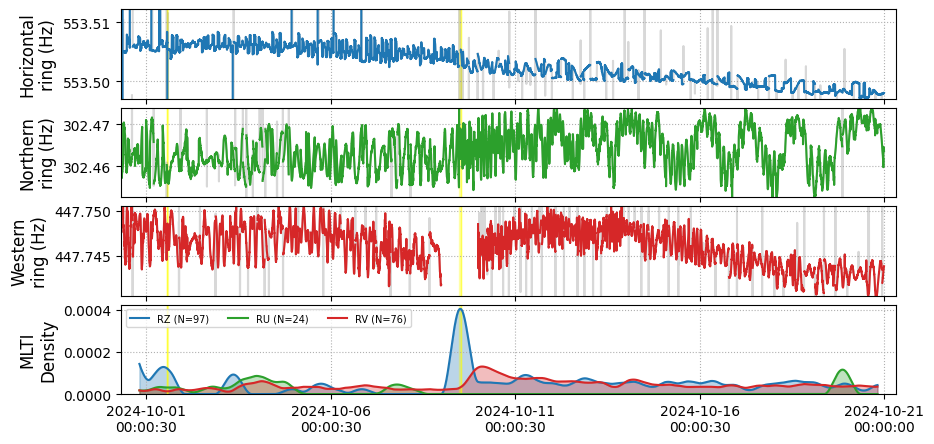

In [16]:
fig = __makeplot();

fig.savefig(config['path_to_figs']+f"html_beatdrift.png", format="png", dpi=150, bbox_inches='tight')

del fig

In [17]:
# from functions.get_fft import __get_fft

In [53]:
# fZ, specZ, _ = __get_fft(beatZ.fj_inter.values, dt=60, window="hann")
# fU, specU, _ = __get_fft(beatU.fj_inter.values, dt=60, window="hann")
# fV, specV, _ = __get_fft(beatV.fj_inter.values, dt=60, window="hann")

Text(0.5, 0, 'Frequenz (Hz)')

Text(0, 0.5, 'Spectral Amplitude')

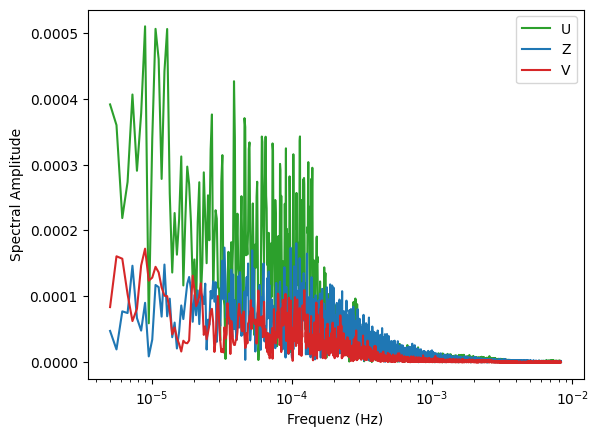

In [55]:
# plt.plot(fU[fU>5e-6], specU[fU>5e-6], color="tab:green", label="U")
# plt.plot(fZ[fZ>5e-6], specZ[fZ>5e-6], color="tab:blue", label="Z")
# plt.plot(fV[fV>5e-6], specV[fV>5e-6], color="tab:red", label="V")

# plt.xscale("log")
# # plt.yscale("log")

# plt.legend()


# plt.xlabel("Frequenz (Hz)")
# plt.ylabel("Spectral Amplitude")